In [1]:
# SPDX-License-Identifier: GPL-3.0-or-later

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import pandas as pd
import os
from scipy.stats import linregress

from matplotlib import pyplot as plt;
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 
plt.rcParams["xtick.minor.width"] = 0.5 
plt.rcParams["ytick.major.width"] = 0.5 
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1


import conntility


In [4]:
savefig_cfg = {"transparent":True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

## First, we check the number of somas that are within 10 $\mu$m of a neuropixels contact
### This shows that the assumption that somas are infinitesimal points have a limited impact on the results

In [5]:
import bluepysnap as bp
path_to_simulation = '/home/joseph-tharayil/Documents/bluebrainStuff/csd_paper/electrodes/'
s = bp.Simulation(path_to_simulation+'simulation_config.json') # Loads simulation object
population_name = 'S1nonbarrel_neurons'


In [6]:
c = s.circuit

In [7]:
hex0Ids = c.nodes.ids('hex0').get_ids()

In [8]:
n = c.nodes['S1nonbarrel_neurons']

In [9]:
somaLocs = n.get(hex0Ids,properties=['x','y','z'])

In [10]:
neuropixelsLocs = pd.read_csv('~/Downloads/electrode_csv.csv').iloc[:,1:4]

In [11]:
distances = []
for s in np.array(somaLocs):
    distances.append(np.linalg.norm(s-neuropixelsLocs,axis=1))
distances = np.array(distances)

In [12]:
np.sum(np.any(distances<10,axis=1))

87

## Next, we check the impact of the assumption that electrode contacts are inifitesimal
### We do this by comparing the weights obtained with infinitesimal electrodes with those calculated with a minimum 6 $\mu$m distance between the neural segment and the electrode

In [13]:
import h5py

In [14]:
# Loads the weights file
coeffsFile = 'lfp_fullNeuropixels.h5'

coeffs = h5py.File(coeffsFile)

coeffsFileC = 'lfp_fullNeuropixels_finite.h5'

coeffs_finite = h5py.File(coeffsFileC)


In [15]:
allValues = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][:][:,:-1]
allValuesFinite = coeffs_finite['electrodes']['S1nonbarrel_neurons']['scaling_factors'][:][:,:-1]


In [16]:
diffs = allValues - allValuesFinite

In [17]:
segmentsWithinSphere = (diffs!=0).astype(int)

In [18]:
segmentsOutsideSphere = np.ones_like(segmentsWithinSphere)-segmentsWithinSphere

In [19]:
diffIdx = np.where(diffs != 0)

In [20]:
gidsWithinSpheres = []
offsets = coeffs['S1nonbarrel_neurons']['offsets'][:]
for idx in diffIdx[0]:
    gid = np.where(idx>offsets)[0][-1]
    gidsWithinSpheres.append(gid)

In [21]:
np.sort(np.abs(diffs.flatten()))

array([0.        , 0.        , 0.        , ..., 0.0003097 , 0.00035882,
       0.00037041])

In [27]:
spikes = np.genfromtxt('out.dat',skip_header=1)

In [29]:
spikingGids = spikes[:,1]

In [32]:
offsets = coeffs['S1nonbarrel_neurons']['offsets'][:]
sortedDiffs = np.sort(np.abs(diffs.flatten()))
for i in np.arange(1,1000):
    segIdx = np.where(np.abs(diffs)==sortedDiffs[-i])[0]
    offsetIdx = np.min(np.where(offsets>segIdx))
    gid = coeffs['S1nonbarrel_neurons']['node_ids'][offsetIdx]
    if gid in spikingGids:
        print(gid)
        print(np.where(np.abs(diffs)==sortedDiffs[-i])[1])
        break

180725
[28]


In [33]:
i

209

In [21]:
np.unravel_index(np.argmax(np.abs(diffs)),np.shape(diffs))

(4009399, 15)

In [55]:
segmentIdx = 6097944

In [57]:
offsetIdx = np.min(np.where(offsets>segmentIdx))

In [58]:
gid = coeffs['S1nonbarrel_neurons']['node_ids'][offsetIdx]

In [59]:
gid

134246

In [23]:
sameIdx = np.where(diffs == 0)

In [24]:
allValuesOutsideSphere = allValues*segmentsOutsideSphere

In [25]:
allValuesWithinSphere = allValues * segmentsWithinSphere

In [26]:
contribWithinSphere = np.sum(allValuesWithinSphere,axis=0) # This corresponds to the total contribution to each electrode from the segments within 6 um of the electrode, assuming a unit current from each segment


In [27]:
contribOutsideSphere = np.sum(allValuesOutsideSphere,axis=0) # This corresponds to the total contribution to each electrode from the segments outside of the spheres, assuming a unit current from each segment


In [28]:
np.mean(allValuesOutsideSphere[allValuesOutsideSphere!=0])

6.55169005795568e-07

In [29]:
np.mean(allValuesWithinSphere[allValuesWithinSphere!=0])

7.090189846564688e-05

In [30]:
np.max(contribWithinSphere/contribOutsideSphere)

0.00043032966831212013

In [31]:
contribOutsideSphere

array([4.62488689, 4.91899944, 5.2113153 , 5.49777154, 5.77400302,
       6.03031277, 6.26708996, 6.47424509, 6.65793851, 6.81738889,
       6.95163778, 7.06395367, 7.16079183, 7.25253258, 7.34464597,
       7.4417617 , 7.54590542, 7.6527232 , 7.75217712, 7.84672175,
       7.93785905, 8.02835502, 8.11436703, 8.19922248, 8.28047252,
       8.35529433, 8.43037171, 8.50582064, 8.57647634, 8.64120034,
       8.68428637, 8.69147988, 8.65103498, 8.5615906 , 8.43467057,
       8.28472945, 8.13508496, 7.99923164, 7.88265108, 7.78946691,
       7.71994034, 7.67390555, 7.64628585, 7.62752176, 7.59065786,
       7.4974282 , 7.31239457, 7.02076952, 6.63841929, 6.18796242,
       5.71137594])

In [32]:
diffs.shape

(11285758, 51)

In [33]:
len(np.unique(diffIdx[0])) # Number of segments within 6 um of an electrode

1361

In [34]:
print(len(diffIdx[0])/(allValues.shape[0]*allValues.shape[1])) # Fraction of segments within 6 um of an electrode

2.3645974430608846e-06


In [35]:
assumptionEffect = allValues[diffIdx]/allValuesFinite[diffIdx] 

In [36]:
np.max(assumptionEffect)

8.736191750211692

In [37]:
len(np.where(assumptionEffect > 3)[0])

45

In [38]:
minDistanceInModel = 1/(4*np.pi*.277*np.max(allValues[diffIdx]))
print(minDistanceInModel*1e-3) # Minimum segment-electrode distance, in um

0.6867981119867946


In [39]:
np.max(allValues)/np.median(allValues)

920.7401045194955

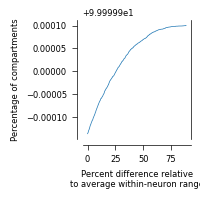

In [28]:
h, b = np.histogram(np.abs(diffs.flatten()/allValues.flatten()),bins=100000)
plt.figure(figsize=(2,2))
ax = plt.gca()

plt.plot(b[1:]*1e2,np.cumsum(h)/np.sum(h)*100)

ax.legend("", frameon=False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_xlabel('Percent difference relative\nto average within-neuron range')
ax.set_ylabel('Percentage of compartments')

#plt.xlim([0,1])
plt.tight_layout()

plt.savefig('cumulative_histogram.png',dpi=600)

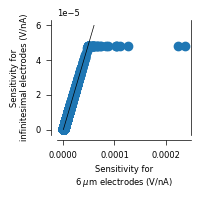

In [21]:
plt.figure(figsize=(2,2))
ax = plt.gca()
plt.plot(allValues[:,30],allValuesFinite[:,30],'o')
plt.plot([0,6e-5],[0,6e-5],'k')

ax.legend("", frameon=False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_xlabel('Sensitivity for\n6 $\mu$m electrodes (V/nA)')
ax.set_ylabel('Sensitivity for\ninfinitesimal electrodes (V/nA)')

plt.tight_layout()

plt.savefig('sensitivity_scatter_plot.png',dpi=600)